In [1]:
import datetime, time
import numpy as np
import simpy
import sys
import shapely.geometry
import pandas as pd
from IPython.display import display

sys.path.append(r"D:\repos\opencl_sim\src")
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
from openclsim.plot.superlog import get_superlog_with_critical_path, SuperLog


In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [3]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": "from_site",
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": "to_site",
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessels[f"vessel{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"barge_{i}",
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=f"cutter",
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels['cutter'] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        amount = np.random.randint(4,6) # handle loading
        duration=np.random.randint(2000,3000) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle{i}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[f"vessel{i}"]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[f"vessel{i}"],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        mover=vessels[f"vessel{i}"],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[f"vessel{i}"].name,
                        registry=registry,
                        processor=vessels[f"vessel{i}"],
                        origin=vessels[f"vessel{i}"],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "from_site":from_site,
        "to_site":to_site,
    }


In [4]:
%%time

res = run(3,100)
vessels = res['vessels']
activities = res['activities']
cutter = vessels['cutter']
to_site = res['to_site']
from_site = res['from_site']

CPU times: total: 78.1 ms
Wall time: 71 ms


In [5]:
fig = plot.get_gantt_chart([*vessels.values(), to_site], id_map=[activities[x] for x in activities])

In [6]:
fig = plot.get_gantt_chart([from_site, to_site, cutter], id_map=[activities[x] for x in activities])

Plot only activities whose namespace (firt letters) matches load*

In [7]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities = []
for a in [*activities]:
    all_activities+=expand(activities[a],'load')
all_activities
fig = plot.get_gantt_chart(all_activities)

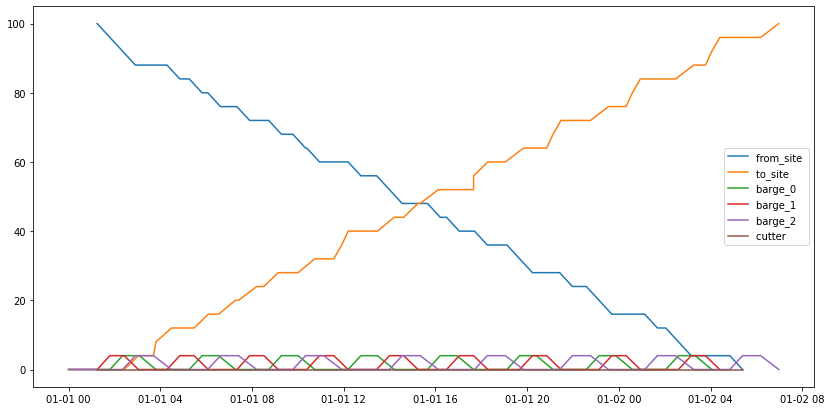

In [8]:
fig = plot.get_step_chart([from_site, to_site, *vessels.values()])

In [9]:
data = []
for i in range(len(vessels.values()) - 1):
    vessel = vessels[f'vessel{i}']
    activity = activities[f'activity{i}']
    sub_act = activity.sub_processes[0].sub_processes[-1]
    log = pd.DataFrame(vessel.log)
    nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "START")])
    data.append({
        'name':vessel.name, 
        'trips':nr_trips, 
        'theoretical production': (sub_act.amount / (4*sub_act.duration+ 5*sub_act.amount)),
        'production':(nr_trips * sub_act.amount) / ((log.Timestamp.max() - log.Timestamp.min()).total_seconds()),
    })
df = pd.DataFrame(data).sort_values(by=['production'],ascending=False)
df

,name,trips,theoretical production,production
1,barge_1,9,0.000445,0.000352
0,barge_0,8,0.000381,0.000317
2,barge_2,8,0.000351,0.000287


Plot with critical path

In [10]:
 # %% run simulation and process output
df_superlog = get_superlog_with_critical_path([*vessels.values(), from_site, to_site],
                                              id_map=[activities[x] for x in activities])
display(df_superlog)

-- total elapsed time 0.1490309238433838 seconds


,Activity,SourceObject,start_time,state,duration,end_time,cp_activity_id,is_critical
0,basic activity:barge_0,barge_0,1970-01-01 00:00:00,ACTIVE,0 days 00:43:37,1970-01-01 00:43:37,cp_activity_1,False
1,basic activity:barge_1,barge_1,1970-01-01 00:00:00,ACTIVE,0 days 00:37:23,1970-01-01 00:37:23,cp_activity_9,True
2,basic activity:barge_2,barge_2,1970-01-01 00:00:00,ACTIVE,0 days 00:47:21,1970-01-01 00:47:21,cp_activity_18,False
3,sailing empty:barge_1,barge_1,1970-01-01 00:37:23,ACTIVE,0 days 00:37:23,1970-01-01 01:14:46,cp_activity_59,True
4,sailing empty:barge_0,barge_0,1970-01-01 00:43:37,ACTIVE,0 days 00:43:37,1970-01-01 01:27:14,cp_activity_51,False
...,...,...,...,...,...,...,...,...
195,loading:barge_2,cutter,1970-01-02 04:50:30,ACTIVE,0 days 00:33:20,1970-01-02 05:23:50,cp_activity_50,True
196,loading:barge_2,from_site,1970-01-02 04:50:30,ACTIVE,0 days 00:33:20,1970-01-02 05:23:50,cp_activity_50,True
197,sailing full:barge_2,barge_2,1970-01-02 05:23:50,ACTIVE,0 days 00:47:21,1970-01-02 06:11:11,cp_activity_100,True
198,unloading:barge_2,barge_2,1970-01-02 06:11:11,ACTIVE,0 days 00:47:21,1970-01-02 06:58:32,cp_activity_125,True


In [11]:
# and plot(ly)
my_log_object = SuperLog(df_superlog)
my_log_object.make_gantt_plotly()

In [12]:
# different setting
res = run(4,100)
vessels = res['vessels']
activities = res['activities']
cutter = vessels['cutter']
to_site = res['to_site']
from_site = res['from_site']
 # %% run simulation and process output
df_superlog = get_superlog_with_critical_path([*vessels.values(), from_site, to_site],
                                              id_map=[activities[x] for x in activities])
display(df_superlog)
# and plot(ly)
my_log_object = SuperLog(df_superlog)
my_log_object.make_gantt_plotly()

-- total elapsed time 0.11700010299682617 seconds


,Activity,SourceObject,start_time,state,duration,end_time,cp_activity_id,is_critical
0,basic activity:barge_0,barge_0,1970-01-01 00:00:00,ACTIVE,0 days 00:33:33,1970-01-01 00:33:33,cp_activity_1,True
1,basic activity:barge_1,barge_1,1970-01-01 00:00:00,ACTIVE,0 days 00:37:46,1970-01-01 00:37:46,cp_activity_7,False
2,basic activity:barge_2,barge_2,1970-01-01 00:00:00,ACTIVE,0 days 00:49:33,1970-01-01 00:49:33,cp_activity_13,False
3,basic activity:barge_3,barge_3,1970-01-01 00:00:00,ACTIVE,0 days 00:39:40,1970-01-01 00:39:40,cp_activity_18,False
4,sailing empty:barge_0,barge_0,1970-01-01 00:33:33,ACTIVE,0 days 00:33:33,1970-01-01 01:07:06,cp_activity_47,True
...,...,...,...,...,...,...,...,...
179,sailing full:barge_3,barge_3,1970-01-01 20:57:58,ACTIVE,0 days 00:39:40,1970-01-01 21:37:38,cp_activity_92,True
180,unloading:barge_2,barge_2,1970-01-01 21:05:51,ACTIVE,0 days 00:49:33,1970-01-01 21:55:24,cp_activity_109,False
181,unloading:barge_2,to_site,1970-01-01 21:05:51,ACTIVE,0 days 00:49:33,1970-01-01 21:55:24,cp_activity_109,False
182,unloading:barge_3,barge_3,1970-01-01 21:37:38,ACTIVE,0 days 00:39:40,1970-01-01 22:17:18,cp_activity_115,True
